# Fine-tune on Fall-page Images

We would fine-tune the pre-trained model on the original dataset, with full-page images. Each unique image ID in the dataset corresponds to a single data sample.

While the base model was primarily trained on single-line text recognition tasks, this experiment aims to assess its ability to generalize to multi-line text extraction. Specifically, we seek to determine whether fine-tuning on full-page images can help mitigate the model's inherent limitations when applied to more complex, multi-line document layouts.

This investigation serves as a critical step in evaluating the model's adaptability and scalability for broader document analysis applications.

## Step 1. Data Processing

### 1.1 Load data

In [66]:
import pandas as pd
df_train=pd.read_csv("df_train.csv")

### 1.2 Convert data into full images

In [2]:
# group words into images
df= df_train.groupby('id')['text'].agg(lambda x: ' '.join(map(str, x))).reset_index()

In [3]:
df['text']=df['text'].astype(str)

In [4]:
df.head()

,id,text
0,00fKvsn,S A S A SA SA S A SAB > < S A SAB SAB S S A S ...
1,01E8WIc,nàgot
2,02VAOf2,Supercalifragilisticexpialidocious Su S
3,03VE0MR,In visions of the dark night I have dreamed of...
4,05Esitx,punch


### 1.3 Token Size
The model has a maximum limitation to the number of tokens (characters) for the one data sample. The maximum is 512.

In [5]:
# we would remove ones that has more than 512 tokens.
# check how many images that have more than 512 tokens
print(len(df[df["text"].str.len()>512])/len(df))

0.06067379849912183


In [6]:
df= df[df["text"].str.len()<=512]

### 1.3 Divide Into Validation and Training sets

In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd

train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)

train_df = train_df.reset_index(drop=True)
eval_df = eval_df.reset_index(drop=True)

### 1.4 Format Data for model training

In [8]:
# common path to images
images_dataset_path= "dataset/"

In [9]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class StyleDataset(Dataset):
    def __init__(self, df, processor, max_target_length=512):
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      try:
          text = self.df['text'][idx]
          if not isinstance(text, str) or not text.strip():
              raise ValueError(f"Invalid text at index {idx}: {repr(text)}")
          image_id = self.df['id'][idx]
          try:
              path= images_dataset_path+ image_id + '.jpg'
              image = Image.open(path).convert("RGB")
          except Exception as e:
              raise ValueError(f"Failed to load image for ID {image_id} at index {idx}") from e
          try:
              pixel_values = self.processor(image, return_tensors="pt").pixel_values
          except Exception as e:
              raise ValueError(f"Image processing failed at index {idx}") from e

          if torch.isnan(pixel_values).any() or torch.isinf(pixel_values).any():
              raise ValueError(f"Invalid pixel values (NaN/inf) at index {idx}")
          try:
              labels = self.processor.tokenizer(
                  text,
                  padding="max_length",
                  max_length=self.max_target_length
              ).input_ids
          except Exception as e:
              raise ValueError(f"Tokenization failed for text at index {idx}") from e

          # Replace pad_token_id with -100 for loss masking
          labels = [
              label if label != self.processor.tokenizer.pad_token_id else -100
              for label in labels
          ]
          encoding = {
              "pixel_values": pixel_values.squeeze(),
              "labels": torch.tensor(labels)
          }

          if encoding["pixel_values"].dim() != 3:
              raise ValueError(f"Invalid pixel_values shape at index {idx}")

          if encoding["labels"].numel() != self.max_target_length:
              raise ValueError(f"Labels length mismatch at index {idx}")

          return encoding

      except Exception as e:
          print(f"\nError in sample {idx}:")
          print(f"   Error type: {type(e).__name__}")
          print(f"   Details: {str(e)}")
          if hasattr(e, '__cause__') and e.__cause__:
              print(f"   Underlying error: {type(e.__cause__).__name__}: {str(e.__cause__)}")
          print(f"   DataFrame row:\n{self.df.iloc[idx]}")
          return None

In [10]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

/common/home/sk2779/courses/cs439/stylized-ocr/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# get base model
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transfor

In [12]:
# Tokenized
train_dataset = StyleDataset(df=train_df,processor=processor)
eval_dataset= StyleDataset(df=eval_df,processor=processor)

In [13]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 4706
Number of validation examples: 1177


In [14]:
# get the label string from enconding
def get_label_str(encoding):
  labels = encoding['labels']
  labels[labels == -100] = processor.tokenizer.pad_token_id
  label_str = processor.decode(labels, skip_special_tokens=True)
  return label_str

In [15]:
get_label_str(train_dataset[0])

'The weak can never forgive. For is the of the A man is but the product of what he thinks, he It is to be too It is healthy reminded might the like your Christ must be the change you in the of'

## Step 2. Set up Model


### 2.1 Model Configration

In [16]:
# Analyze your dataset first
avg_target_len = df['text'].apply(len).mean()
print("average target length", avg_target_len)
max_target_len = int(df['text'].apply(len).quantile(0.95))
print("maximum target length", max_target_len)

average target length 100.96311405745368
maximum target length 361


In [17]:
# Token Alignment
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = len(processor.tokenizer)

In [18]:
from transformers import GenerationConfig

generation_config = GenerationConfig(
    max_length=64,
    early_stopping=True,
    num_beams=4,
    length_penalty=2.0,
    no_repeat_ngram_size=3,
    eos_token_id=processor.tokenizer.sep_token_id,
    decoder_start_token_id=processor.tokenizer.cls_token_id,
    pad_token_id=processor.tokenizer.pad_token_id,
    skip_special_tokens=True  # Added for consistent decoding
)

### 2.2 Metrics

In [19]:
from evaluate import load
cer_metric = load("cer")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

## Step 3. Fine-tune

In [20]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    eval_strategy="steps",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=True,
    output_dir="./output/models/",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
    num_train_epochs=6,
    generation_config=generation_config)

In [21]:
from transformers import default_data_collator
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    processing_class=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/common/home/sk2779/courses/cs439/stylized-ocr/venv/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:152: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss,Cer
200,3.244500,7.627956,0.976138
400,2.544300,7.465873,2.818918
600,2.468700,7.375311,1.002039
800,1.280700,7.289715,0.909472
1000,0.542200,7.218556,1.667851
1200,1.776300,7.125396,1.001343
1400,1.781800,7.027740,1.172091
1600,1.814300,6.915971,1.036023


/common/home/sk2779/courses/cs439/stylized-ocr/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/common/home/sk2779/courses/cs439/stylized-ocr/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1770, training_loss=1.7312502141726218, metrics={'train_runtime': 4924.4959, 'train_samples_per_second': 5.734, 'train_steps_per_second': 0.359, 'total_flos': 2.1128580652962152e+19, 'train_loss': 1.7312502141726218, 'epoch': 6.0})

## Step 4. Evaluate

### 4.1 Load model

In [42]:
from transformers import VisionEncoderDecoderModel

model_path = "./output/models/checkpoint-1770"
model =  VisionEncoderDecoderModel.from_pretrained(model_path).to("cuda")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

### 4.2 Load Testing Dataset

In [74]:
df_test=pd.read_csv("df_test.csv")
df_test= df_test.groupby('id')['text'].agg(lambda x: ' '.join(map(str, x))).reset_index()
df_test.head()

,id,text
0,01dWS6L,/buns spritE Tomato vanilla cakE 1:45 pm Gift:...
1,01xGl1w,never give up on something you can't go a day ...
2,02gnTwX,Area- Mixed 2) Shapes
3,03YZwao,ck back e
4,04y100y,"fields, index. data being n or n: ertain fields"


### 4.3 Do Inference

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [79]:
def readText_batch(df, indices):
    """Process multiple images at once"""
    paths = [image_dataset_path + df['id'][idx] + '.jpg' for idx in indices]
    images= [Image.open(path).convert("RGB") for path in paths]
    pixel_values = processor(images=images, return_tensors="pt").pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    return processor.batch_decode(generated_ids, skip_special_tokens=True)

def process_all_rows_batched(df, batch_size=8):
    results = []
    for i in tqdm(range(0, len(df), batch_size), desc="Processing batches"):
        batch_indices = range(i, min(i+batch_size, len(df)))
        try:
            batch_texts = readText_batch(df, batch_indices)
            for idx, text in zip(batch_indices, batch_texts):
                results.append({
                    'id': df['id'][idx],
                    'preds': df['text'][idx],
                    'labels': text
                })
        except Exception as e:
            print(f"Error in batch {i//batch_size}: {str(e)}")
            for idx in batch_indices:
                results.append({
                    'id': df['id'][idx],
                    'labels': df['text'][idx],
                    'preds': None,
                    'error': str(e)
                })
    return pd.DataFrame(results)

In [80]:
results_df = process_all_rows_batched(df_test, batch_size=8)

Processing batches: 100%|██████████| 196/196 [06:10<00:00,  1.89s/it]


In [82]:
results_df.head()

,id,true_text,predicted_text
0,01dWS6L,/buns spritE Tomato vanilla cakE 1:45 pm Gift:...,The brown jumps the dog the brown lazy... quic...
1,01xGl1w,never give up on something you can't go a day ...,you you you you I you I I I you you my I I my ...
2,02gnTwX,Area- Mixed 2) Shapes,abcijmnopruvxy
3,03YZwao,ck back e,"""you"
4,04y100y,"fields, index. data being n or n: ertain fields",you you you


### 4.4 Evaluate

In [85]:
# to analyze character difference rate, remove all the spaces into one token
results_df["pred"]= results_df["predicted_text"].str.replace(' ', '')
results_df["label"]= results_df["true_text"].str.replace(' ', '')

In [112]:
from evaluate import load
cer = load("cer")

def compute_eval_metrics(pred_str, label_str):
    pred_str=pred_str.strip()
    label_str=label_str.strip()
    # max_len = max(len(pred_str), len(label_str))
    # pred_str = pred_str.ljust(max_len)  
    # label_str = label_str.ljust(max_len)
    try: 
        score = cer.compute(predictions=[pred_str], references=[label_str])
        return score
    except Exception as e:
        print("error", e)
        print(type(pred_str), len(pred_str), pred_str)
        print(type(label_str), len(label_str), label_str)
        return None

In [121]:
from tqdm import tqdm
tqdm.pandas()  # Enable progress_apply for pandas

results_df["metrics"] = results_df.progress_apply(
    lambda row: compute_eval_metrics(row["predicted_text"], row["true_text"]),
    axis=1
)

100%|██████████| 1565/1565 [27:20<00:00,  1.05s/it]


### 4.4 Analyze Performance

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

def plot_eval(values):
    # Plotting
    plt.figure(figsize=(8, 5))
    sns.kdeplot(values, shade=True)
    plt.xlabel("Edit Distance")
    plt.title("KDE of Edit Distances")
    plt.show()
        
    # Boxplot
    plt.boxplot(values, vert=False, patch_artist=True)
    plt.xlabel("Edit Distance")
    plt.title("Boxplot of Edit Distances")
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_658790/805715199.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(values, shade=True)


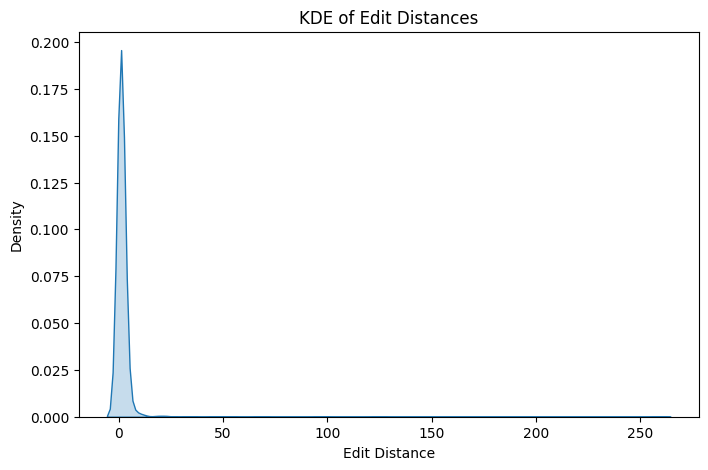

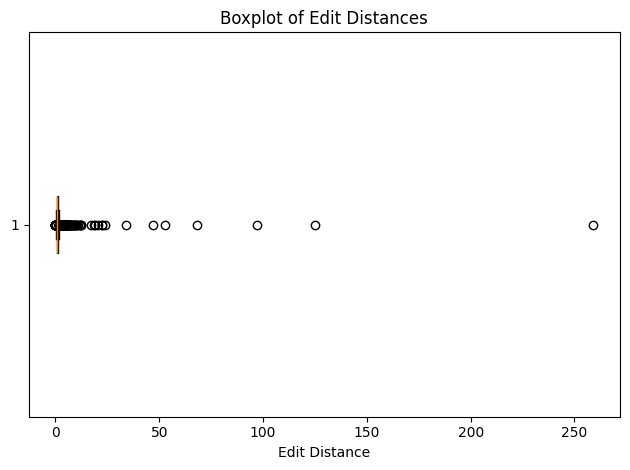

In [123]:
plot_eval(results_df["metrics"])

/tmp/ipykernel_658790/805715199.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(values, shade=True)


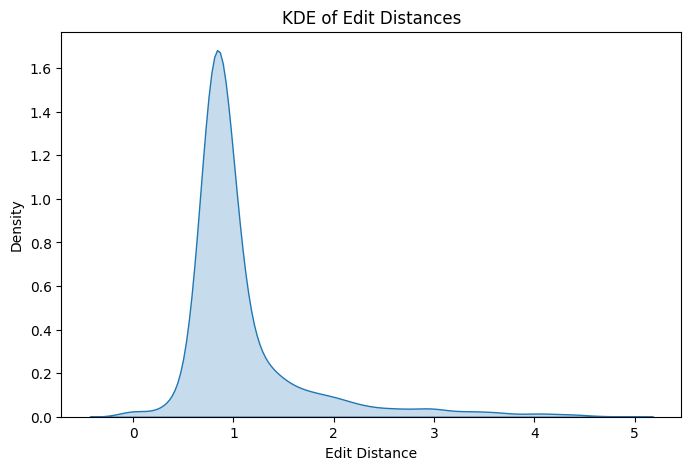

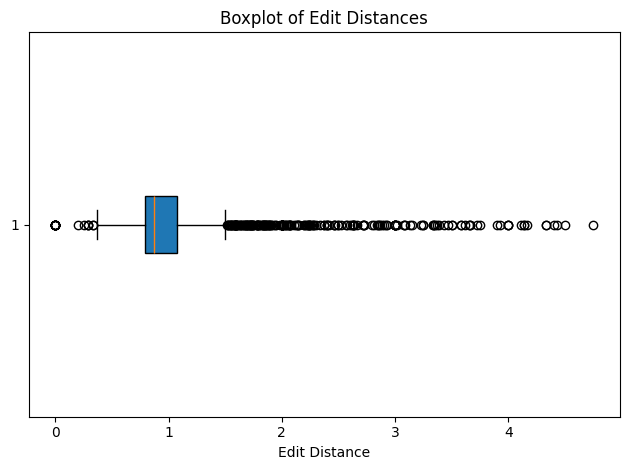

In [124]:
# remove outliers
results_normal= results_df[results_df["metrics"]<5]
plot_eval(results_normal["metrics"])

In [125]:
import numpy as np
def show_state(values):
    stats = {
        "mean": np.mean(values),
        "median": np.median(values),
        "std": np.std(values),
        "min": np.min(values),
        "max": np.max(values),
        "quantiles": np.quantile(values, [0.25, 0.5, 0.75]),
    }
    
    # 3. Print results
    print("Summary Statistics:")
    print(f"- Mean ± Std: {stats['mean']:.2f} ± {stats['std']:.2f}")
    print(f"- Median (IQR): {stats['median']:.2f} ({stats['quantiles'][0]:.2f}–{stats['quantiles'][2]:.2f})")
    print(f"- Range: [{stats['min']}, {stats['max']}]")
    print(f"- Quantiles (25th, 50th, 75th): {stats['quantiles'].round(2)}")

In [126]:
show_state(results_df["metrics"])

Summary Statistics:
- Mean ± Std: 1.76 ± 8.22
- Median (IQR): 0.88 (0.79–1.15)
- Range: [0.0, 259.0]
- Quantiles (25th, 50th, 75th): [0.79 0.88 1.15]
